In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import librosa
import mpl_scatter_density
import umap
from tqdm import tqdm_notebook as tqdm

In [2]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [3]:
import json
import pandas as pd
import os

# OpenL3 embeddings

In [4]:
openmic_train = set(pd.read_csv('/home/bmcfee/working/wimir2019/openmic2018_train.csv', header=None)[0])

In [5]:
# load the openmic data
files = librosa.util.find_files('/home/bmcfee/working/wimir2019/openmic-openl3/', ext='npz')

In [6]:
LIMIT = -1

X = []
Y = []
for fn in tqdm(files):
    if os.path.splitext(os.path.basename(fn))[0] not in openmic_train:
        continue
    data = np.load(fn)
    xi = data['embedding'][:LIMIT]
    yi = [0] * len(xi)
    X.extend(xi)
    Y.extend(yi)

In [7]:
# load the irmas
files = librosa.util.find_files('/home/bmcfee/working/wimir2019/irmas-openl3/', ext='npz')

In [8]:
for fn in tqdm(files):
    data = np.load(fn)
    xi = data['embedding'][:LIMIT]
    yi = [1] * len(xi)
    X.extend(xi)
    Y.extend(yi)

In [9]:
X = np.asarray(X, dtype=np.float16)
Y = np.asarray(Y, dtype=np.uint8)

In [10]:
X.shape, Y.shape

((1584550, 512), (1584550,))

---

In [28]:
U = umap.UMAP(verbose=True)

In [29]:
U.fit(np.take(X, np.random.randint(0, len(X), size=50000), axis=0))

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Tue Nov  5 02:00:55 2019 Finding Nearest Neighbors
Tue Nov  5 02:00:55 2019 Building RP forest with 16 trees
Tue Nov  5 02:00:58 2019 NN descent for 16 iterations


/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/py37/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
Tue Nov  5 02:01:12 2019 Finished Nearest Neighbor Search
Tue Nov  5 02:01:14 2019 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Nov  5 02:02:06 2019 Finished embedding


UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)

In [30]:
#embedding = U.embedding_
embedding = U.transform(X)

/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/py37/lib/python3.7/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  self.func_ir.loc))
/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/py37/lib/python3.7/s

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs


In [31]:
colors = ['orange', 'green']
data = ['OpenMIC', 'IRMAS']

/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


Text(0.5, 1.0, 'OpenL3 - raw')

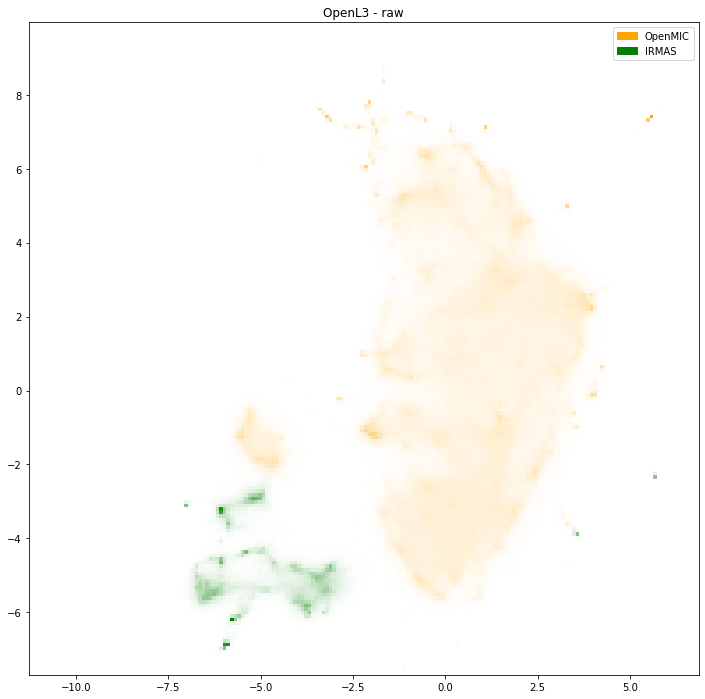

In [32]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

handles = []

for c in [0, 1]:
    ax.scatter_density(embedding[Y == c][:, 0], embedding[Y==c][:, 1], color=colors[c], dpi=25)
    handles.append(mpatches.Patch(color=colors[c], label=data[c]))
    
plt.legend(handles=handles)

xlim = np.quantile(embedding[:,0], [0.01, 0.99])
ylim = np.quantile(embedding[:,1], [0.01, 0.99])
plt.axis('equal')
plt.xlim(xlim * 1.75)
plt.ylim(ylim * 1.75)
plt.title('OpenL3 - raw')

In [13]:
LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
LDA.fit(X, Y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
                           solver='eigen', store_covariance=False, tol=0.0001)

In [14]:
v = LDA.coef_.copy()
v /= np.sqrt(np.sum(v**2))
A = np.outer(v, v)

In [15]:
np.trace(A)

1.0

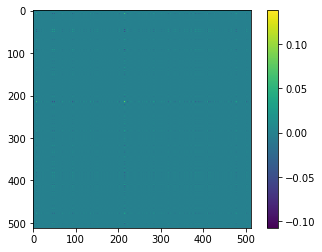

In [16]:
plt.imshow(A, aspect='equal')
plt.colorbar()

In [17]:
#Xs = scaler.transform(X)
#Xdeb = Xs - Xs.dot(A)
Xdeb = X.dot(np.eye(len(A)) - A)

In [18]:
#Xsproj = Xs.dot(v.T)
Xsproj = LDA.transform(X)

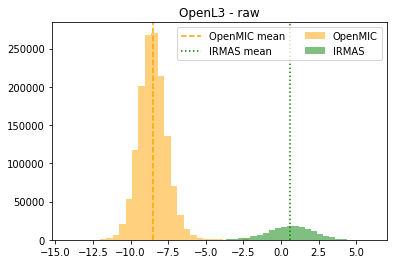

In [22]:
plt.title('OpenL3 - raw')
plt.hist(Xsproj[Y==0], color=colors[0], alpha=0.5, label=data[0], bins=30)
plt.hist(Xsproj[Y==1], color=colors[1], alpha=0.5, label=data[1], bins=30)
plt.axvline(Xsproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(data[0]))
plt.axvline(Xsproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(data[1]))
plt.legend(ncol=2)

In [20]:
Xdproj = LDA.transform(Xdeb)
#Xdproj = Xdeb.dot(v.T)

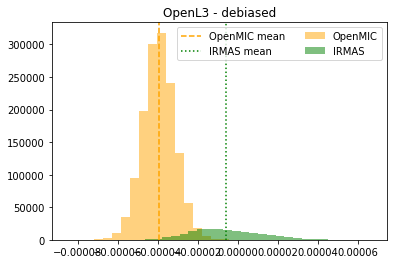

In [23]:
plt.title('OpenL3 - debiased')
plt.hist(Xdproj[Y==0], color=colors[0], alpha=0.5, label=data[0], bins=30)
plt.hist(Xdproj[Y==1], color=colors[1], alpha=0.5, label=data[1], bins=30)
plt.axvline(Xdproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(data[0]))
plt.axvline(Xdproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(data[1]))
plt.legend(ncol=2)

In [24]:
U2 = umap.UMAP(verbose=True)

In [25]:
U2.fit(np.take(Xdeb, np.random.randint(0, len(Xdeb), size=50000), axis=0))

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Tue Nov  5 01:43:01 2019 Finding Nearest Neighbors
Tue Nov  5 01:43:01 2019 Building RP forest with 16 trees


/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/py37/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))


Tue Nov  5 01:43:05 2019 NN descent for 16 iterations


/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/py37/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

F

	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
Tue Nov  5 01:43:20 2019 Finished Nearest Neighbor Search
Tue Nov  5 01:43:23 2019 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Nov  5 01:44:18 2019 Finished embedding


UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)

In [26]:
#emb2 = U2.embedding_
emb2 = U2.transform(Xdeb)

/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/py37/lib/python3.7/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  self.func_ir.loc))
/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/py37/lib/python3.7/s

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs


/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


Text(0.5, 1.0, 'OpenL3 - debiased')

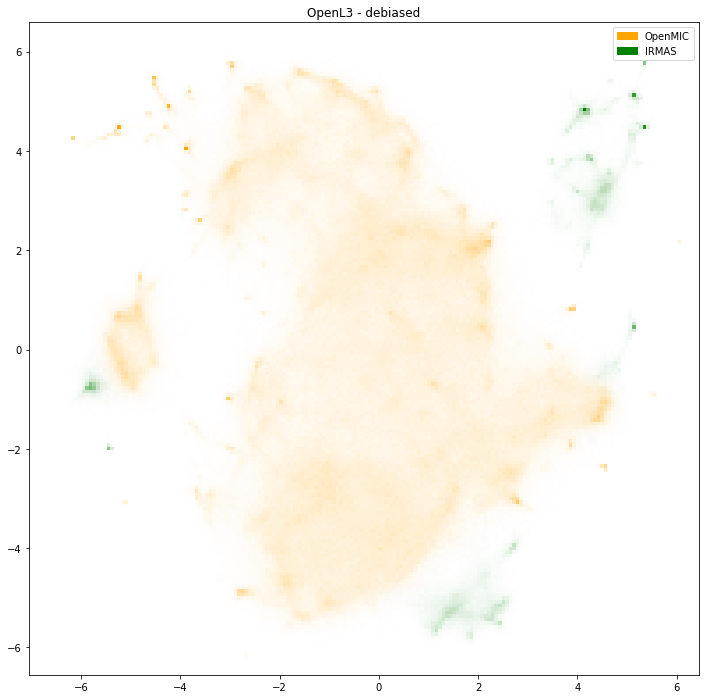

In [27]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

handles = []

for c in [0, 1]:
    ax.scatter_density(emb2[Y == c][:, 0], emb2[Y==c][:, 1], color=colors[c], dpi=25)
    handles.append(mpatches.Patch(color=colors[c], label=data[c]))
    
plt.legend(handles=handles)

xlim = np.quantile(emb2[:,0], [0.01, 0.99])
ylim = np.quantile(emb2[:,1], [0.01, 0.99])
plt.axis('equal')
#plt.xlim(xlim * 1)
plt.ylim(ylim * 1.75)
plt.title('OpenL3 - debiased')

---
# VGGish

In [33]:
# load the openmic data
files = librosa.util.find_files('/home/bmcfee/working/wimir2019/openmic-vggish/', ext='json')

In [34]:
LIMIT = -1
X = []
Y = []
for fn in tqdm(files):
    if os.path.splitext(os.path.basename(fn))[0] not in openmic_train:
        continue
    data = json.load(open(fn, 'r'))
    xi = data['features'][:LIMIT]
    yi = [0] * len(xi)
    X.extend(xi)
    Y.extend(yi)

In [35]:
# load the irmas
files = librosa.util.find_files('/home/bmcfee/working/wimir2019/irmas-vggish/', ext='json')

In [36]:
for fn in tqdm(files):
    data = json.load(open(fn, 'r'))
    xi = data['features'][:LIMIT]
    yi = [1] * len(xi)
    X.extend(xi)
    Y.extend(yi)

In [37]:
X = np.asarray(X, dtype=np.float16)
Y = np.asarray(Y, dtype=np.uint8)

In [38]:
X.shape, Y.shape

((147645, 128), (147645,))

---

In [39]:
U = umap.UMAP(verbose=True)

In [40]:
#U.fit(X)
U.fit(np.take(X, np.random.randint(0, len(X), size=50000), axis=0))

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Tue Nov  5 02:12:04 2019 Finding Nearest Neighbors
Tue Nov  5 02:12:04 2019 Building RP forest with 16 trees
Tue Nov  5 02:12:06 2019 NN descent for 16 iterations


/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/py37/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
Tue Nov  5 02:12:15 2019 Finished Nearest Neighbor Search
Tue Nov  5 02:12:17 2019 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Nov  5 02:13:08 2019 Finished embedding


UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)

In [41]:
#embedding = U.embedding_
embedding = U.transform(X)

/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/py37/lib/python3.7/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  self.func_ir.loc))
/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/py37/lib/python3.7/s

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs


In [42]:
colors = ['black', 'red']
data = ['OpenMIC', 'IRMAS']

/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


Text(0.5, 1.0, 'VGGish - raw')

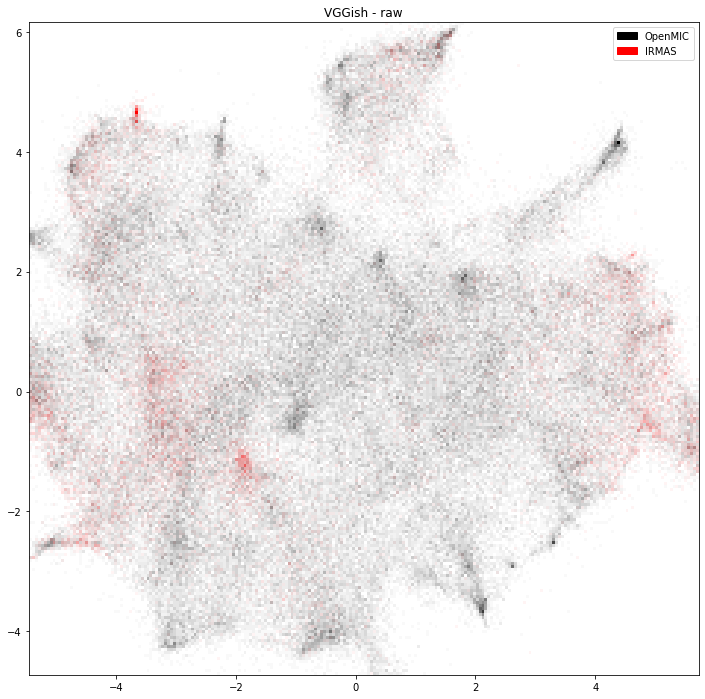

In [43]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

handles = []
for c in [0, 1]:
    ax.scatter_density(embedding[Y == c][:, 0], embedding[Y==c][:, 1], color=colors[c], label=data[c], dpi=30)
    handles.append(mpatches.Patch(color=colors[c], label=data[c]))
    
    plt.legend(handles=handles)
    

xlim = np.quantile(embedding[:,0], [0.01, 0.99])
ylim = np.quantile(embedding[:,1], [0.01, 0.99])

plt.axis('equal')

plt.xlim(xlim * 1.1)
plt.ylim(ylim * 1.1)

plt.title('VGGish - raw')

In [44]:
#scaler = StandardScaler()
LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
LDA.fit(X, Y)
#pipe = Pipeline([('scaler', scaler), ('LDA', LDA)])
#idx = np.random.randint(0, len(X), size=50000)
#pipe.fit(X[idx], Y[idx])
#pipe.fit(X, Y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage='auto',
                           solver='eigen', store_covariance=False, tol=0.0001)

In [45]:
v = LDA.coef_.copy()
v /= np.sqrt(np.sum(v**2))
A = np.outer(v, v)

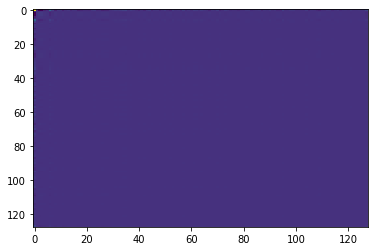

In [46]:
plt.imshow(A, aspect='auto')

In [48]:
#Xs = scaler.transform(X)
#Xdeb = Xs - Xs.dot(A)
Xdeb = X.dot(np.eye(len(A)) - A)

In [49]:
#Xsproj = Xs.dot(v.T)
Xsproj = LDA.transform(X)

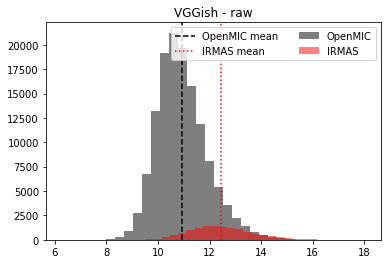

In [50]:
plt.title('VGGish - raw')
plt.hist(Xsproj[Y==0], color=colors[0], alpha=0.5, label=data[0], bins=30)
plt.hist(Xsproj[Y==1], color=colors[1], alpha=0.5, label=data[1], bins=30)
plt.axvline(Xsproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(data[0]))
plt.axvline(Xsproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(data[1]))
plt.legend(ncol=2)

In [51]:
Xdproj = LDA.transform(Xdeb)
#Xdproj = Xdeb.dot(v.T)

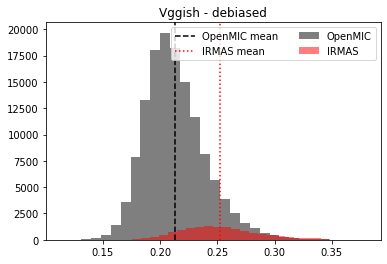

In [52]:
plt.title('Vggish - debiased')
plt.hist(Xdproj[Y==0], color=colors[0], alpha=0.5, label=data[0], bins=30)
plt.hist(Xdproj[Y==1], color=colors[1], alpha=0.5, label=data[1], bins=30)
plt.axvline(Xdproj[Y==0].mean(), color=colors[0], linestyle='--', label='{} mean'.format(data[0]))
plt.axvline(Xdproj[Y==1].mean(), color=colors[1], linestyle=':', label='{} mean'.format(data[1]))
plt.legend(ncol=2)

In [54]:
U2 = umap.UMAP(verbose=True)

In [55]:
#U2.fit(Xdeb)
U2.fit(np.take(Xdeb, np.random.randint(0, len(Xdeb), size=50000), axis=0))

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Tue Nov  5 02:14:46 2019 Finding Nearest Neighbors
Tue Nov  5 02:14:46 2019 Building RP forest with 16 trees
Tue Nov  5 02:14:47 2019 NN descent for 16 iterations


/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/py37/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
Tue Nov  5 02:14:57 2019 Finished Nearest Neighbor Search
Tue Nov  5 02:14:59 2019 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Tue Nov  5 02:15:52 2019 Finished embedding


UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=True)

In [56]:
#emb2 = U2.embedding_
emb2 = U2.transform(Xdeb)

/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/py37/lib/python3.7/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  self.func_ir.loc))
/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../miniconda3/envs/py37/lib/python3.7/s

	completed  0  /  30 epochs
	completed  3  /  30 epochs
	completed  6  /  30 epochs
	completed  9  /  30 epochs
	completed  12  /  30 epochs
	completed  15  /  30 epochs
	completed  18  /  30 epochs
	completed  21  /  30 epochs
	completed  24  /  30 epochs
	completed  27  /  30 epochs


/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:74: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/bmcfee/miniconda3/envs/py37/lib/python3.7/site-packages/mpl_scatter_density/generic_density_artist.py:79: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


Text(0.5, 1.0, 'VGGish - debiased')

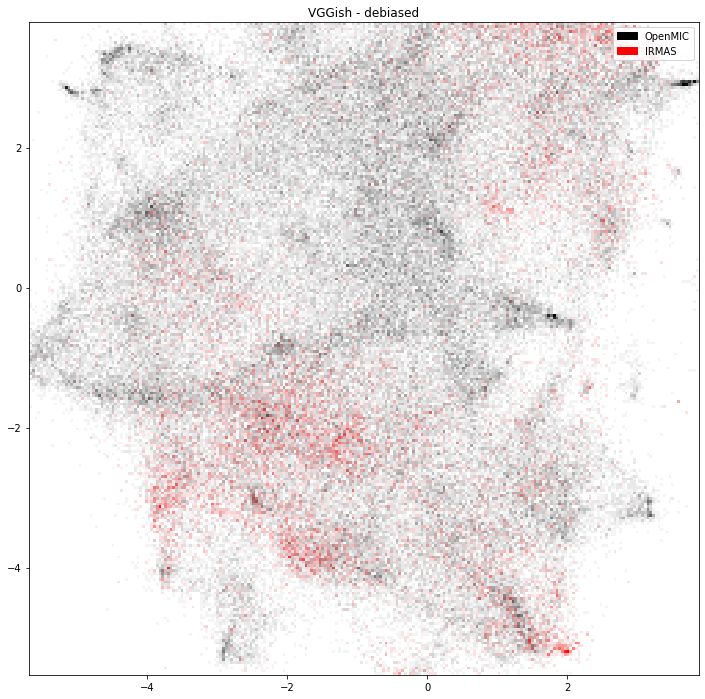

In [57]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')

handles = []

for c in [0, 1]:
    ax.scatter_density(emb2[Y == c][:, 0], emb2[Y==c][:, 1], color=colors[c], dpi=32)
    handles.append(mpatches.Patch(color=colors[c], label=data[c]))
    
plt.legend(handles=handles)



xlim = np.quantile(emb2[:,0], [0.01, 0.99])
ylim = np.quantile(emb2[:,1], [0.01, 0.99])

plt.axis('equal')

plt.xlim(xlim * 1.1)
plt.ylim(ylim * 1.1)

plt.title('VGGish - debiased')